
# 270. 컴퓨터 비전(Vision)을 위한 전이학습(Transfer Learning)
=======================================================

- 실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에, (무작위 초기화를 통해) 처음부터 합성곱 신경망(Convolutional Network) 전체를 작성하는 경우는 매우 적다.   


- 대신, 매우 큰 데이터셋(예. 100가지 분류에 대해 120만개의 이미지가 포함된 ImageNet)에서 합성곱 신경망(ConvNet)을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업을 위한 초기 설정 또는 고정된 특징 추출기(fixed feature extractor)로 사용

### 전이학습의 2 가지 시나리오:

-  **합성곱 신경망의 미세조정(finetuning)**: 신경망을 ImageNet 등으로 미리 학습한 신경망으로 초기화하고 parameter 미세 조정  


-  **고정된 특징 추출기로써의 합성곱 신경망**: 마지막 완전 연결층을 제외한 모든 신경망의 가중치를 고정. 마지막의 완전 연결층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습.  


### torch 제공 pre-trained models
```
    import torchvision.models as models  
    
    resnet18 = models.resnet18()  
    alexnet = models.alexnet()  
    vgg16 = models.vgg16()  
    squeezenet = models.squeezenet1_0()  
    densenet = models.densenet161()  
    inception = models.inception_v3()  
    googlenet = models.googlenet()  
    shufflenet = models.shufflenet_v2_x1_0()  
    mobilenet = models.mobilenet_v2()  
    resnext50_32x4d = models.resnext50_32x4d()  
    wide_resnet50_2 = models.wide_resnet50_2()  
    mnasnet = models.mnasnet1_0()  
```   

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

# 프로그램 실행 중 사용할 수 있는 임시 폴더 생성
# 블록 벗어나면 자동 삭제
from tempfile import TemporaryDirectory

cudnn.benchmark = True    # 최적의 알고리즘을 자동 선택
plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


데이터 불러오기
---------------

- **개미** 와 **벌** 을 분류하는 이진 분류 모델을 학습
    - 대략 120장 정도의 훈련 이미지와, 75장의 검증용 이미지를 이용
    - 전이학습을 통해 소량의 데이터로도 일반화 가능
    - ImageNet의 일부 data 이용

-  데이터를 [여기](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   에서 다운로드 받아 현재 디렉토리에 압축을 푼다

In [2]:
!wget  https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q "hymenoptera_data.zip"

--2025-07-19 07:59:50--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.106, 99.86.38.37, 99.86.38.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   249MB/s    in 0.2s    

2025-07-19 07:59:50 (249 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
# 데이터 증가(augmentation) 및 ResNet 에 적합한 normalization 적용
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 이미지를 무작위 크기 및 비율로 자른 후 224x224로 조정
        transforms.RandomHorizontalFlip(),  # 이미지를 50% 확률로 수평으로 뒤집음
        transforms.ToTensor(),                      # 이미지를 PyTorch 텐서로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 텐서의 채널별 평균 및 표준편차를 사용하여 정규화
    ]),

    'val': transforms.Compose([
        transforms.Resize(256),            # 이미지의 짧은 측을 256 픽셀로 조정
        transforms.CenterCrop(224),     # 이미지 중앙을 224x224 크기로 자름
        transforms.ToTensor(),               # 이미지를 PyTorch 텐서로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 텐서의 채널별 평균 및 표준편차를 사용하여 정규화
    ]),
}

# ImageFolder 라이브러리

- 계층적인 폴더 구조를 가지고 있는 데이터셋을 불러올 때 사용할 수 있다. 각 이미지들이 자신의 레이블(Label) 이름으로 된 폴더 안에 들어가 있는 구조라면, ImageFolder 라이브러리를 이용하여 이를 바로 불러와 객체로 만들면 된다.

ImageFolder를 사용하기 위해선 가장 먼저 수집된 데이터의 폴더구조를 아래와 같이 설계해야한다  

최상위 경로 아래에 각각의 class name을 가지는 폴더를 구성하고 그 하위경로에 이미지가 저장되어있는 방식이다.
```
root_dir
    | --- ants/
    |      |-- 0001.jpg
    |      |-- 0002.jpg
    |      |-- ...
    | --- bees/
    |      |-- 0001.jpg
    |      |-- 0002.jpg
    |      |-- ...
    | --- rabbit/
    |      |--...
```

In [5]:
data_dir = 'hymenoptera_data'
train_dir = os.path.join(data_dir, 'train')
val_dir  = os.path.join(data_dir, 'val')

print(os.listdir(data_dir))
print(os.listdir(train_dir))
print(os.listdir(val_dir))

['train', 'val']
['bees', 'ants']
['bees', 'ants']


### `datasets.ImageFolder(folder, transform)` data loader 생성

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),  data_transforms[x])
                                for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
                               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
print(image_datasets)
print(dataloaders)
print(dataset_sizes)
print(class_names)

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
{'train': <torch.utils.data.dataloader.DataLoader object at 0x781b7d85f410>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x781c63721690>}
{'train': 244, 'val': 

### 일부 이미지 시각화하기

- `torchvision.utils.make_grid(tensor)`  
  - `tensor (Tensor 또는 list)`: 4차원 텐서 `(B x C x H x W)` 형태의 미니 배치 텐서 또는 같은 크기의 이미지 리스트입니다. (여기서 B는 이미지 개수, C는 채널 수, H와 W는 이미지의 높이와 너비)  
  - `nrow (int, 선택)`: 한 줄에 표시할 이미지 개수입니다. 최종 그리드는 `(B / nrow, nrow)` 형태가 됩니다. 기본값은 8입니다.

In [8]:
def imshow(inp, title=None):
    # 입력 텐서 차원을 재배열. PyTorch - [C, H, W], matplotlib - [H, W, C]
    inp = inp.numpy().transpose(1, 2, 0)

    # 이미지를 정규화할 때 사용된 평균과 표준편차를 정의 - 모델이 학습될 때 사용된 값들
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    # 정규화된 이미지 데이터를 원래의 범위로 되돌립니다.
    inp = inp * std + mean

    # np.clip 함수를 사용하여 이미지 데이터의 값이 0과 1 사이로 제한됩니다.
    inp = np.clip(inp, 0, 1)

    # 이미지 위에 제목 표시
    if title is not None:
        plt.title(title)

    plt.imshow(inp)

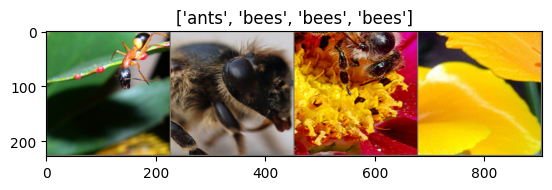

In [9]:
# 훈련 데이터 로더에서 첫 번째 배치를 가져옵니다.
inputs, classes = next(iter(dataloaders['train']))

# 가져온 이미지 배치를 그리드 형태로 만듭니다.
out = torchvision.utils.make_grid(inputs)

# 만들어진 이미지 그리드를 시각화합니다.
imshow(out, title=[class_names[x] for x in classes])

Model Train
--------------

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()  # 학습 시작 시간 저장

    # 임시 디렉토리 생성 (학습 중 가장 성능이 좋은 모델을 여기에 저장)
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        # 현재 모델의 초기 상태를 저장 (기준점)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0  # 최고 검증 정확도 저장 변수

        # 에폭 반복
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # 각 에폭은 훈련(Train)과 검증(Validation) 두 단계로 구성됨
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 학습 모드로 전환
                else:
                    model.eval()   # 모델을 평가 모드로 전환

                running_loss = 0.0     # 누적 손실값 초기화
                running_corrects = 0  # 정확하게 예측한 개수 초기화

                # 현재 단계의 데이터셋을 반복
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 이전 단계의 gradient 초기화
                    optimizer.zero_grad()

                    # 순전파 수행
                    # 학습 단계일 때만 gradient 기록
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)               # 모델 출력 계산
                        _, preds = torch.max(outputs, 1)      # 예측 클래스 추출
                        loss = criterion(outputs, labels)     # 손실 계산

                        # 학습 단계일 경우 역전파 및 최적화 수행
                        if phase == 'train':
                            loss.backward()      # gradient 계산
                            optimizer.step()      # 가중치 업데이트

                    # 손실과 정확도 누적 계산
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                # 학습 단계일 경우 스케줄러로 learning rate 갱신
                if phase == 'train':
                    scheduler.step()

                # epoch의 평균 손실과 정확도 계산
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # 검증 단계에서 정확도가 최고 기록이면 모델 저장
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()  # 에폭 종료 시 공백 출력

        # 전체 학습 시간 계산 및 출력
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # 가장 정확도가 높았던 모델의 가중치 불러오기
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model  # 최적 모델 반환

모델 예측 시각화

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training        # 원래 모델이 학습 모드였는지 기억해 둠
    model.eval()               # 모델을 평가 모드로 전환 (Dropout, BatchNorm 등이 비활성화됨)
    images_so_far = 0     # 시각화한 이미지 수를 카운트
    fig = plt.figure()           # 새로운 figure 생성

    with torch.inference_mode():         # 추론 시 gradient 계산 비활성화 (메모리, 속도 최적화)
        for i, (inputs, labels) in enumerate(dataloaders['val']):    # 검증용 배치 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)            # 모델 추론 수행
            _, preds = torch.max(outputs, 1)  # 각 샘플에 대해 예측 클래스 추출

            for j in range(inputs.size()[0]):    # 배치 내 이미지 반복
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)   # subplot 생성
                ax.axis('off')      # 축 제거
                ax.set_title(f'predicted: {class_names[preds[j]]}')   # 예측된 클래스 이름 표시

                imshow(inputs.cpu().data[j])    # 이미지 시각화 (imshow 함수는 사용자 정의 함수로 가정)

                if images_so_far == num_images:
                    model.train(mode=was_training)    # 원래 모드로 복원
                    return    # 지정한 수만큼 출력했으면 종료

        model.train(mode=was_training)  # 루프가 끝나도 원래 모드로 복원

## 방법 1. pre-trained  ConvNet 신경망 전체를 미세조정(finetuning)

- 미리 학습된 모델을 불러온 후 마지막의 완전 연결층 만을 새로 작성하고 **전체 parameter** 를 fine tuning

In [12]:
# 사전 학습된 ResNet-18 모델을 불러옴 (ImageNet 학습 가중치 사용)
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# ResNet의 마지막 fully-connected 층(fc)의 입력 feature 수 추출
num_ftrs = model_ft.fc.in_features

# 출력 클래스 수를 2개로 설정
model_ft.fc = nn.Linear(num_ftrs, 2)

# 모델을 device로 이동
model_ft = model_ft.to(device)

# 손실 함수 설정
criterion = nn.CrossEntropyLoss()

# 옵티마이저 설정 (SGD: 확률적 경사하강법, 학습률 0.001, 모멘텀 0.9)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 학습률 스케줄러 설정: 7 에폭마다 학습률을 0.1배씩 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


In [13]:
# 학습 함수(train_model)를 호출하여 모델 학습 시작
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6210 Acc: 0.6803
val Loss: 0.2450 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5397 Acc: 0.7623
val Loss: 0.2329 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4840 Acc: 0.7869
val Loss: 0.1635 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.5443 Acc: 0.7910
val Loss: 0.3460 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.4289 Acc: 0.8238
val Loss: 0.2757 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.4299 Acc: 0.8156
val Loss: 0.4842 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.4632 Acc: 0.8402
val Loss: 0.3606 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3672 Acc: 0.8402
val Loss: 0.2840 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3758 Acc: 0.8443
val Loss: 0.2750 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.2381 Acc: 0.8975
val Loss: 0.2184 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2897 Acc: 0.8566
val Loss: 0.2422 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.2816 Acc: 0.8893
val Loss: 0.2333 Acc: 0.8954

Ep

# 학습된 모델(model_ft)을 시각화하여 예측 결과를 확인
 - 검증 데이터셋에서 일부 이미지를 가져와 모델이 예측한 클래스 이름과 함께 이미지 출력
 -  총 6개의 이미지를 보여줌 (기본값 num_images=6)

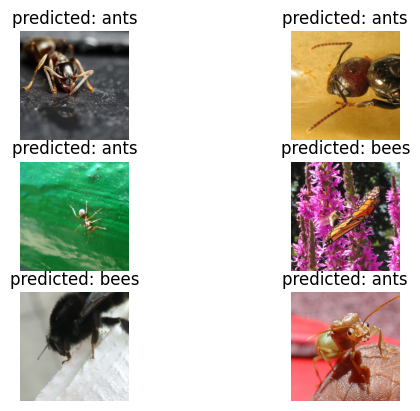

In [14]:
visualize_model(model_ft)

## 방법 2 : Pre-trained ConvNet을 weight 고정된 특징 추출기로 사용

- 미리 학습된 모델을 불러온 후 마지막의 **완전 연결층 만을 새로 작성**하되 마지막 계층을 제외한 **신경망의 모든 부분을 고정** (``requires_grad = False`` 로 설정)하여 ``backward()`` 중에 gradient가 계산되지 않도록 함

In [15]:
# 사전 학습된 ResNet-18 모델 로드 (ImageNet 가중치 사용)
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# 모든 파라미터의 requires_grad 값을 False로 설정하여 고정시킴
# → 기존 가중치는 학습되지 않음 (feature extractor로만 사용)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 정의할 fully-connected 레이어(fc)의 입력 특징 수 추출
num_ftrs = model_conv.fc.in_features

# 출력층(fc)을 이진 분류용으로 교체 (출력 클래스 수 = 2)
# 새로 생성한 fc 레이어의 파라미터는 기본적으로 requires_grad=True → 학습 가능
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

# 손실 함수 설정
criterion = nn.CrossEntropyLoss()

# 옵티마이저 설정:
# 이전과 달리 model_conv 전체가 아닌 fc 레이어의 파라미터만 최적화 대상
# 즉, 출력층만 학습되고 나머지 레이어는 고정됨
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 학습률 스케줄러 설정: 7 에폭마다 학습률을 0.1배씩 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 훈련 및 평가

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6294 Acc: 0.6557
val Loss: 0.3579 Acc: 0.8301

Epoch 1/24
----------
train Loss: 0.4965 Acc: 0.7582
val Loss: 0.2078 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5078 Acc: 0.7582
val Loss: 0.2000 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4526 Acc: 0.7910
val Loss: 0.2031 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4513 Acc: 0.7787
val Loss: 0.1988 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3698 Acc: 0.8361
val Loss: 0.1846 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4923 Acc: 0.8238
val Loss: 0.3043 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3394 Acc: 0.8320
val Loss: 0.1833 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2528 Acc: 0.8975
val Loss: 0.1704 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4392 Acc: 0.7951
val Loss: 0.1887 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3534 Acc: 0.8238
val Loss: 0.2021 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2984 Acc: 0.8689
val Loss: 0.1922 Acc: 0.9281

Ep

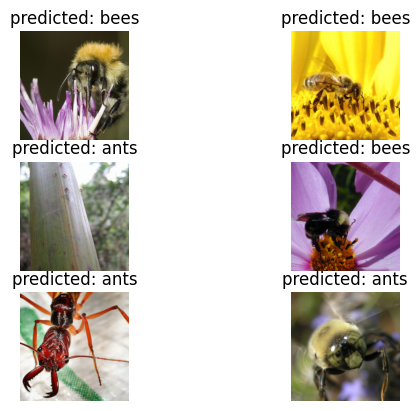

In [17]:
# 학습된 모델(model_conv)을 이용해 검증 데이터셋에서 예측 결과를 시각화
visualize_model(model_conv)

# 인터랙티브 모드를 끄고 명시적으로 plt.show() 호출할 때까지 기다리도록 설정
plt.ioff()

# 누적된 그래프/이미지 시각화를 화면에 출력
plt.show()

### 사용자 정의 이미지에 대한 추론
훈련된 모델을 사용하여 사용자 정의 이미지에 대한 예측을 하고 예측된 클래스 레이블을 이미지와 함께 시각화합니다

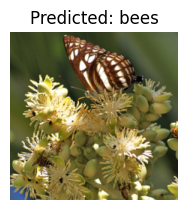

In [23]:
model = model_ft
# model = model_conv

img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg'

model.eval()    # 모델을 평가 모드로 전환 (Dropout, BatchNorm 비활성화)

# 이미지 열기
img = Image.open(img_path)

# 검증 데이터에 사용된 변환(transform) 적용
img = data_transforms['val'](img)  # 예: Resize, ToTensor, Normalize 등

# 배치 차원을 추가 (모델 입력 형태: [1, C, H, W])
img = img.unsqueeze(0)

img = img.to(device)

# 추론 실행 (gradient 비활성화 → 메모리, 속도 효율적)
with torch.inference_mode():
    outputs = model(img)                # 모델 출력 계산
    _, preds = torch.max(outputs, 1)    # 가장 높은 확률을 가진 클래스 인덱스 선택

# 시각화: 2x2 서브플롯 중 첫 번째 칸에 이미지 출력
ax = plt.subplot(2, 2, 1)
ax.axis('off')  # 축 정보 제거
ax.set_title(f'Predicted: {class_names[preds[0]]}')  # 예측된 클래스 이름 출력
imshow(img.cpu().data[0])  # 이미지를 시각화 (텐서를 다시 CPU로 이동해서 표시)

plt.ioff()
plt.show()

In [24]:
predictions = []
labels = []

# 모델을 평가 모드로 설정
with torch.inference_mode():
    for x, y in dataloaders['val']:
        x, y = x.to(device), y.to(device)
        z = model(x)
        # 출력값 중 최대값을 가진 인덱스를 예측값으로 선택
        preds = z.argmax(1)

        # 예측값을 predictions 리스트에 추가
        predictions.extend(preds.cpu().numpy())
        # 실제 레이블을 labels 리스트에 추가
        labels.extend(y.cpu().numpy())

    # 예측값과 실제 레이블이 일치하는 인덱스를 찾음
    correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
    # 예측값과 실제 레이블이 불일치하는 인덱스를 찾음
    incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

# 정확도를 계산하여 출력
print(f"accuracy = {len(correct_indices) / len(predictions) * 100:.2f} %")

accuracy = 94.12 %
